In [1]:
import tweepy
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt
import random

### 1. Configuration and Authentication 
---
This is the setup part and API authentication. Prior to using the API it is necessary to create a developer account, the account grants you two levels of access. A user level and an application/project level. I will be using **configparser** to ensure my API keys are not visible. I suggest you do the same. The following is how to set up the configuration process.


1.  create a project from the developer's portal
2.  generate your API and access keys
3.  save them in a 'config.ini' file in the following format:
   
    ``` ini
    [twitter]
    CONSUMER_KEY = 'YOUR CONSUMER KEY'
    CONSUMER_SECRET = 'YOUR CONSUMER SECRET'
    ACCESS_TOKEN = 'YOUR ACCESS TOKEN'
    ACCESS_TOKEN_SECRET = 'YOUR ACCESS TOKEN SECRET' 
    ```
   
4. install configparser by running  `pip install configparser`

> **Note:** If you don't plan on using the config parser make sure you remove the import and change the next cell accordingly. To eliminate any errors. Make sure you adhere to the same variable names!

In [2]:
# read the file from 'config.ini' 
config = configparser.ConfigParser()
config.read('config.ini')

# API Variables
CONSUMER_KEY = config['twitter']['CONSUMER_KEY']
CONSUMER_SECRET = config['twitter']['CONSUMER_SECRET']
ACCESS_TOKEN = config['twitter']['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = config['twitter']['ACCESS_TOKEN_SECRET']

In [3]:
# authenticate using tweepy
def twitter_setup():
    auth = tweepy.OAuth1UserHandler(CONSUMER_KEY, CONSUMER_SECRET)  # project access
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)  # user access

    api = tweepy.API(auth = auth)
    return api

extractor = twitter_setup() 

### 2. Data Collection
---
After setting up the credentials and authenticating the project. I can start extracting data using **tweepy's** API. The aim is to search different terms and different hashtags in order to collect as much entries as the API allows for. There are many limitations since I have the `Elevated Access`. The main ones is that the search API only allows search to go back 7 days. One way this was managed was starting the project early. However, the ideal goal is to be able to search the entire archive. Nonetheless, the project aims to measure the opinion at the current time. Therefore, the regular search will suffice!

I have created a function that when called extracts tweets depending on a local list. This list can have as many search queires as anyone would like. Also, The function parses the needed information and stores it in a data frame. Upon each iteration it appends to the previous data frame. This is beneficial when storing the data in .csv files.

In [4]:
def extract_tweets():
    tweets = []  # main data frame
    data = [] # temporary data frame
    columns_header = ['ID', 'Tweet', 'Timestamp', 'Likes', 'Retweets', 'Length']
    search_terms = ['@expo2020dubai -filter:retweets',
                    '#expo2020 -filter:retweets',
                    '#اكسبو -filter:retweets',
                    'اكسبو دبي -filter:retweets']  # search terms

    # fetch the tweets once prior to the iteration to append things correctly
    collected_tweets = tweepy.Cursor(extractor.search_tweets, q='expo dubai -filter:retweets', lang='ar', tweet_mode='extended').items(600)

    for tweet in collected_tweets:
        data.append([tweet.id, tweet.full_text, tweet.created_at,tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)])

    tweets = pd.DataFrame(data=data, columns=columns_header) # store in original data frame

    for term in search_terms:
        data = []
        collected_tweets = tweepy.Cursor(extractor.search_tweets, q=term, lang='ar', tweet_mode='extended').items(600)

        for tweet in collected_tweets:
            data.append([tweet.id, tweet.full_text, tweet.created_at, tweet.favorite_count, tweet.retweet_count, len(tweet.full_text)])

        df = pd.DataFrame(data=data, columns=columns_header)
        frames = [tweets, df]  
        tweets = pd.concat(frames) # append the data frame to the previous one

    # since we are appending data frames the index value changes each time
    # here the goal is to create a new index that is incremented by one 
    tweets.insert(0, 'index', range(0, len(tweets))) 
    tweets = tweets.set_index('index')

    # random number to ensure files don't get overwritten
    tweets.to_csv('Tweets\\tweets155.csv')
    
    return tweets

In [5]:
tweets = extract_tweets()

### 3. Preliminary Data Exploration

In [6]:
display(tweets.head())
display(tweets.tail())
print('total of collected tweets is ', len(tweets))

ID                                              Tweet  \
index                                                                           
0      1515012076397371392  غرفة تجارة دبي تكشف أن 76.5% من شركات القطاع ا...   
1      1514974893149986823  في شهر فبراير 2022.\nالمدير التنفيذي للميلان إ...   
2      1514923695294324739  @jihadebenalluch و ها قد نسيتي انك ذهبتي للمؤت...   
3      1514861082552193029  بات #إكسبو2020 دبي تجربة لا تنسى لسكان دولة #ا...   
4      1514564741552869376  Saudi Arabia’s pavilion at Expo 2020 Dubai: a ...   

                      Timestamp  Likes  Retweets  Length  
index                                                     
0     2022-04-15 17:00:01+00:00      1         2     206  
1     2022-04-15 14:32:16+00:00     28         0     302  
2     2022-04-15 11:08:49+00:00      1         0     131  
3     2022-04-15 07:00:01+00:00      1         0     212  
4     2022-04-14 11:22:28+00:00      1         0     276

ID                                              Tweet  \
index                                                                           
701    1514627428492230663  @Forsan_UAE 192 دولة.\n.\n#إكسبو_2020_دبي \n.\...   
702    1514627394421854229            @Forsan_UAE 192دوله \n\n#اكسبو_2020_دبي   
703    1514627371252555777  @Forsan_UAE 192 دولة.\n.\n#إكسبو_2020_دبي \n.\...   
704    1514627119351054341  @Forsan_UAE 192 دولة.\n.\n#إكسبو_2020_دبي \n.\...   
705    1514627085360410624           @Forsan_UAE 192 دولة \n\n#إكسبو_2020_دبي   

                      Timestamp  Likes  Retweets  Length  
index                                                     
701   2022-04-14 15:31:34+00:00      0         0      48  
702   2022-04-14 15:31:25+00:00      0         0      37  
703   2022-04-14 15:31:20+00:00      0         0      48  
704   2022-04-14 15:30:20+00:00      0         0      48  
705   2022-04-14 15:30:12+00:00      0         0      38

total of collected tweets is  706


In [7]:

tweets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 706 entries, 0 to 705
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   ID         706 non-null    int64              
 1   Tweet      706 non-null    object             
 2   Timestamp  706 non-null    datetime64[ns, UTC]
 3   Likes      706 non-null    int64              
 4   Retweets   706 non-null    int64              
 5   Length     706 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(1)
memory usage: 38.6+ KB


### 4. Data Visualization

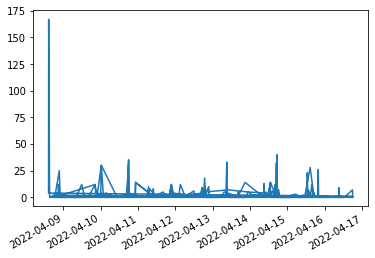

In [8]:
plt.plot(tweets['Timestamp'], tweets['Likes'])
plt.gcf().autofmt_xdate()
plt.show()

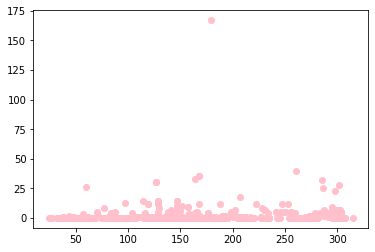

In [9]:
plt.scatter(tweets['Length'], tweets['Likes'], color='pink')
plt.show()


In [10]:
# tweets1 = pd.read_csv('tweets1.csv')
# tweets2 = pd.read_csv('tweets3.csv')
# tweets3 = pd.read_csv('tweets327.csv')
# tweets4 = pd.read_csv('tweets1439.csv')
# tweets5 = pd.read_csv('tweets526.csv')
# tweets6 = pd.read_csv('tweets546.csv')
# tweets7 = pd.read_csv('tweets129.csv')
# tweets8 = pd.read_csv('tweets1700.csv')

# tweets1 = tweets1.drop(['Unnamed: 0'], axis=1)
# tweets2 = tweets2.drop(['Unnamed: 0'], axis=1)
# tweets3 = tweets3.drop(['index'], axis=1)
# tweets4 = tweets4.drop(['index'], axis=1)
# tweets5 = tweets5.drop(['index'], axis=1)
# tweets6 = tweets6.drop(['index'], axis=1)
# tweets7 = tweets7.drop(['index'], axis=1)
# tweets8 = tweets8.drop(['index'], axis=1)



# frames = [tweets1, tweets2, tweets3, tweets4, tweets5, tweets6, tweets7, tweets8]
# final_tweets = pd.concat(frames)  # append the data frame to the previous one
# final_tweets.insert(0, 'index', range(0, len(final_tweets)))
# final_tweets = final_tweets.set_index('index')

# display(final_tweets.head())
# display(final_tweets.tail())

# final_tweets.to_csv('dirty_tweets_updated.csv')
